# OpenCV Face Recognition

There are three methods available in OpenCV:
- Eigen Faces
- Fisher Faces
- Local Binary Patterns Histogram

In [76]:
import os, sys, dlib
import cv2
import math
import numpy as np
import _pickle as cPickle
import faceBlendCommon as fbc
import matplotlib.pyplot as plt
from dataPath import DATA_PATH
%matplotlib inline


In [77]:
import matplotlib
matplotlib.rcParams['figure.figsize'] = (6.0,6.0)
matplotlib.rcParams['image.cmap'] = 'gray'
matplotlib.rcParams['image.interpolation'] = 'bilinear'

faceWidth = 64
faceHeight = 64

In [78]:
def alignFace(imFace, landmarks):
  l_x = landmarks[39][0]
  l_y = landmarks[39][1]
  r_x = landmarks[42][0]
  r_y = landmarks[42][1]

  # find angle between eyes point
  dy = r_y - l_y
  dx = r_x - l_x
  # Convert from radians to degrees
  angle = math.atan2(dy, dx) * 180.0 / math.pi  

  # find center points between eyes point
  eyesCenter = ((l_x + r_x)*0.5, (l_y + r_y)*0.5)
  rotMatrix = cv2.getRotationMatrix2D(eyesCenter, angle, 1)
  alignedImFace = np.zeros(imFace.shape, dtype=np.uint8)
  alignedImFace = cv2.warpAffine(imFace, rotMatrix, 
                  (imFace.shape[1],imFace.shape[0]))

  return alignedImFace

In [79]:
# Now let's prepare our training data
imagesFolder = DATA_PATH + 'dlap_week4/images/FaceRec/trainFaces'
subfolders = []

for x in os.listdir(imagesFolder):
    xpath = os.path.join(imagesFolder, x)
    if os.path.isdir(xpath):
        subfolders.append(xpath)

In [80]:
imagePaths = []
labels = []

labelsMap = {}
labelsMap[-1] = "unknown"

for i, subfolder in enumerate(subfolders):
    labelsMap[i] = os.path.basename(subfolder)
    for x in os.listdir(subfolder):
        xpath = os.path.join(subfolder, x)
        if x.endswith('jpg') or x.endswith('pgm'):
            imagePaths.append(xpath)
            labels.append(i)

imagesFaceTrain = []
labelsFaceTrain = []

In [81]:
# Load face detector
faceDetector = dlib.get_frontal_face_detector() 

# Load landmark detector.
landmarkDetector = dlib.shape_predictor(DATA_PATH + "models/shape_predictor_68_face_landmarks.dat")

In [82]:
for j, imagePath in enumerate(imagePaths):
    im = cv2.imread(imagePath, 0)
    imHeight, imWidth = im.shape[:2]
    
    # Detect faces in the image
    # Find landmarks.
    landmarks = fbc.getLandmarks(faceDetector, landmarkDetector, im)
    landmarks = np.array(landmarks)
    if len(landmarks) < 68:
        #print("{}, Only {} Landmarks located".format(imagePath,len(landmarks)))
        continue
    #else:
        #print("Processing : {}".format(imagePath))

    # below code calculates the bounding box limits around a face by 
    # extending specific distances based on facial landmarks.
    x1Limit = landmarks[0][0] - (landmarks[36][0] - landmarks[0][0])
    x2Limit = landmarks[16][0] + (landmarks[16][0] - landmarks[45][0])
    y1Limit = landmarks[27][1] - 3*(landmarks[30][1] - landmarks[27][1])
    y2Limit = landmarks[8][1] + (landmarks[30][1] - landmarks[29][1])

    x1 = max(x1Limit,0)
    x2 = min(x2Limit, imWidth)
    y1 = max(y1Limit, 0)
    y2 = min(y2Limit, imHeight)
    imFace = im[y1:y2, x1:x2]

    alignedFace = alignFace(imFace, landmarks)
    alignedFace = cv2.resize(alignedFace, (faceHeight, faceWidth))

    imagesFaceTrain.append(np.float32(alignedFace)/255.0)
    labelsFaceTrain.append(labels[j])

In [83]:
# Train using eigen faces
faceRecognizerEigen = cv2.face.EigenFaceRecognizer_create()
print("Training using Eigen Faces")
faceRecognizerEigen.train(imagesFaceTrain, np.array(labelsFaceTrain))
faceRecognizerEigen.write('face_model_eigen.yml')

Training using Eigen Faces


In [84]:
# Train using fisher faces

faceRecognizerFisher = cv2.face.FisherFaceRecognizer_create()
print("Training using Fisher Faces")
faceRecognizerFisher.train(imagesFaceTrain, 
                          np.array(labelsFaceTrain))
faceRecognizerFisher.write('face_model_fisher.yml')

Training using Fisher Faces


In [85]:
# Train using LBPH faces

faceRecognizerLBPH = cv2.face.LBPHFaceRecognizer_create()
print("Training using LBP Histograms")

faceRecognizerLBPH.train(imagesFaceTrain, 
                       np.array(labelsFaceTrain))
faceRecognizerLBPH.write('face_model_lbph.yml')

# save label number to label names mapping
with open('labels_map.pkl', 'wb') as f:
    cPickle.dump(labelsMap, f)

Training using LBP Histograms


In [86]:
import glob
VIDEO = 0
"""
'l' = LBPH
'f' = Fisher
'e' = Eigen
"""
MODEL = 'l' 

In [87]:
if VIDEO:
    cam = cv2.VideoCapture(DATA_PATH + "dlap_week4/videos/face1.mp4")
else:
    testFiles = glob.glob(DATA_PATH + "dlap_week4/images/FaceRec/testFaces/*.jpg")
    testFiles.sort()
    i = 0
    correct = 0
    error = 0

In [88]:
if MODEL == 'e':
    # Create a face recognizer object
    faceRecognizer = cv2.face.EigenFaceRecognizer_create()
    # load model from disk
    faceRecognizer.read('face_model_eigen.yml')
elif MODEL == 'f':
    # Create a face recognizer object
    faceRecognizer = cv2.face.FisherFaceRecognizer_create()
    # load model from disk
    faceRecognizer.read('face_model_fisher.yml')
elif MODEL == 'l':
    # Create a face recognizer object
    faceRecognizer = cv2.face.LBPHFaceRecognizer_create()
    # load model from disk
    faceRecognizer.read('face_model_lbph.yml')

In [89]:
# load label numbers to label names mapping
labelsMap = np.load('labels_map.pkl', allow_pickle=True)

# Load face detector
faceDetector = dlib.get_frontal_face_detector() 

# Load landmark detector.
landmarkDetector =  dlib.shape_predictor(DATA_PATH + "models/shape_predictor_68_face_landmarks.dat")

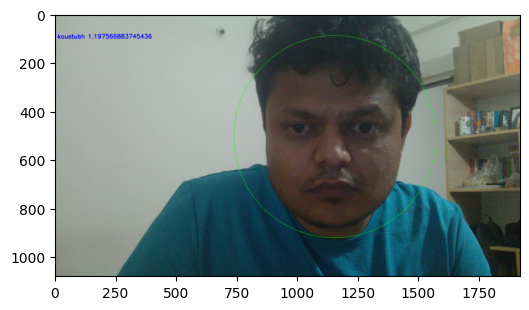

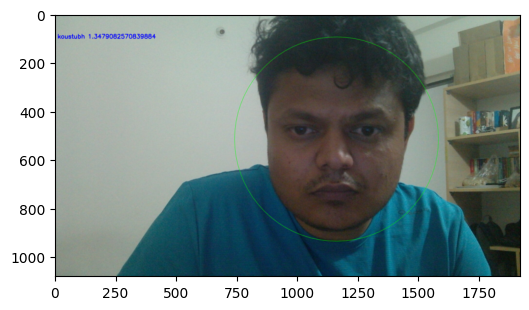

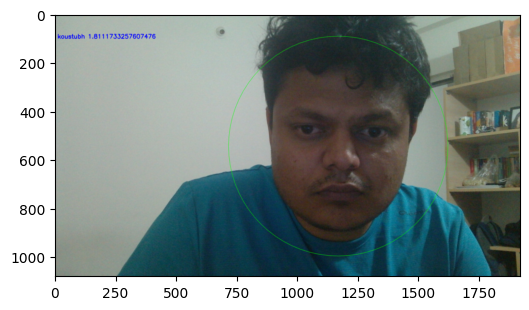

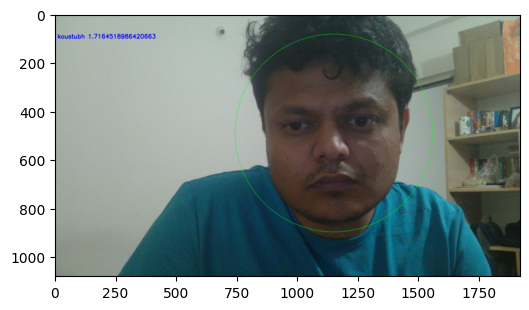

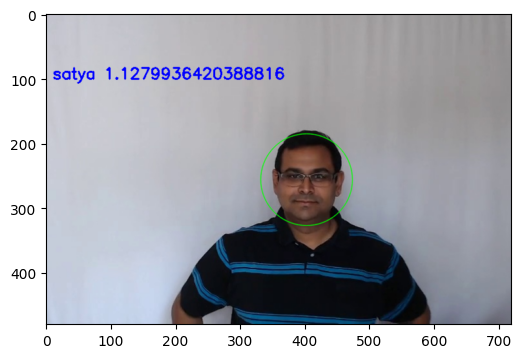

In [ ]:
# We will display only 5 results
count = 0
while (VIDEO or (i < len(testFiles))) and (count < 5):
    if VIDEO:
      success, original = cam.read()
      original = cv2.resize(original, (640, 480))
      if not success:
        print('cannot capture input from camera')
        break

    else:
      imagePath = testFiles[i]
      original = cv2.imread(imagePath)
      i += 1

    im = cv2.cvtColor(original,cv2.COLOR_BGR2GRAY)

    imHeight, imWidth = im.shape[:2]

    # Find landmarks.
    landmarks = fbc.getLandmarks(faceDetector, landmarkDetector, im)
    landmarks = np.array(landmarks)
    if len(landmarks) < 68:
      print("Only {} Landmarks located".format(len(landmarks)))
      continue

    # below code calculates the bounding box limits around a face by 
    # extending specific distances based on facial landmarks.
    x1Limit = landmarks[0][0] - (landmarks[36][0] - landmarks[0][0])
    x2Limit = landmarks[16][0] + (landmarks[16][0] - landmarks[45][0])
    y1Limit = landmarks[27][1] - 3*(landmarks[30][1] - landmarks[27][1])
    y2Limit = landmarks[8][1] + (landmarks[30][1] - landmarks[29][1])

    x1 = max(x1Limit,0)
    x2 = min(x2Limit, imWidth)
    y1 = max(y1Limit, 0)
    y2 = min(y2Limit, imHeight)
    imFace = im[y1:y2, x1:x2]

    alignedFace = alignFace(imFace, landmarks)
    alignedFace = cv2.resize(alignedFace, (faceHeight, faceWidth))
    imFaceFloat = np.float32(alignedFace)/255.0

    predictedLabel = -1
    predictedLabel, score = faceRecognizer.predict(imFaceFloat)
    center = ( int((x1 + x2) /2), int((y1 + y2)/2) )
    radius = int((y2-y1)/2.0)
    cv2.circle(original, center, radius, (0, 255, 0), 1, lineType=cv2.LINE_AA);
    cv2.putText(original, '{} {}'.format(labelsMap[predictedLabel],score), (10,100), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255, 0, 0), 2);

    plt.imshow(original[:,:,::-1])
    plt.show()
    count += 1